In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, mutual_info_score, roc_auc_score
from sklearn.tree import DecisionTreeRegressor, export_text

%matplotlib inline

# Data preparation

In [2]:
remote_csv = 'wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'

!wget $remote_csv -O data.csv

--2023-10-27 11:00:28--  http://wget/
Resolving wget (wget)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address ‘wget’
--2023-10-27 11:00:28--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.36M  2.35MB/s    in 0.6s    

2023-10-27 11:00:34 (2.35 MB/s) - ‘data.csv’ saved [1423529/1423529]

FINISHED --2023-10-27 11:00:34--
Total wall clock time: 5.9s
Downloaded: 1 files, 1.4M in 0.6s (2.35 MB/s)


In [3]:
orig_df = pd.read_csv('data.csv')
orig_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df_prep = orig_df[orig_df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
df_prep = df_prep.reset_index(drop=True)

In [5]:
df_prep = df_prep.fillna(0)

df_prep.isna().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

In [6]:
seed = 1

df_full_train, df_test = train_test_split(df_prep, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(y_train_orig)
y_val = np.log1p(y_val_orig)
y_test = np.log1p(y_test_orig)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [7]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

# Question 1

In [8]:
model = DecisionTreeRegressor(random_state=seed, max_depth=1)
model.fit(X_train, y_train)

model

DecisionTreeRegressor(max_depth=1, random_state=1)

In [9]:
print(export_text(model, feature_names=dv.get_feature_names_out()))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



# Question 2

In [10]:
from sklearn.metrics import mean_squared_error

def calculate_rmse(y, y_pred):
    err = y - y_pred
    sq_err = err ** 2
    mse = sq_err.mean()
    return np.sqrt(mse)

In [11]:
# not really sure, but it seems like it should be the Regressor and not Classifier
# since we're making predictions on the median_house_value. The lecture used 
# Classifier since we were making predictions on status.

rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [12]:
y_pred = rf.predict(X_val)

#val_rmse = calculate_rmse(y_val, y_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
val_rmse

0.24518772479229903

# Question 3

In [13]:
rmse = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, n_jobs=-1, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse.append((n, val_rmse))

df_rmse = pd.DataFrame(rmse, columns=['n_estimators', 'rmse'])
df_rmse.head()

,n_estimators,rmse
0,10,0.245188
1,20,0.238674
2,30,0.236887
3,40,0.235265
4,50,0.234869


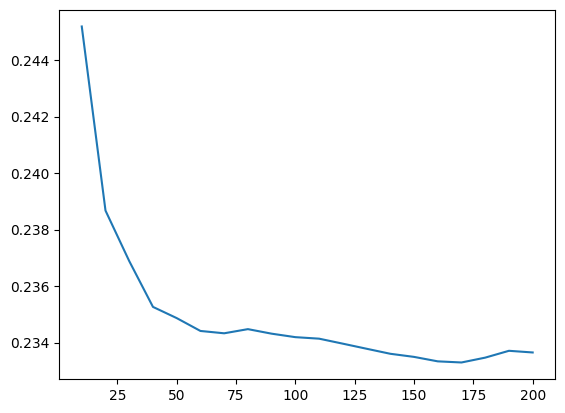

In [14]:
plt.plot(df_rmse.n_estimators, df_rmse.rmse)

# Question 4

In [15]:
depths = [10, 15, 20, 25]
estimator_steps = range(10, 201, 10)
num_estimators = len(list(estimator_steps))
rmse = []

for d in depths:
    total_rmse = 0
    for n in estimator_steps:
        rf = RandomForestRegressor(n_estimators=n, n_jobs=-1, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict(X_val)
        val_rmse = calculate_rmse(y_val, y_pred)
        total_rmse += val_rmse
    mean_rmse = total_rmse / num_estimators
    print(mean_rmse)
    rmse.append((d, n, mean_rmse))

df_rmse = pd.DataFrame(rmse, columns=['max_depth', 'n_estimators', 'rmse'])
df_rmse

0.24545499602392812
0.23592063364139698
0.2351513449194707
0.23482586603902927


,max_depth,n_estimators,rmse
0,10,200,0.245455
1,15,200,0.235921
2,20,200,0.235151
3,25,200,0.234826


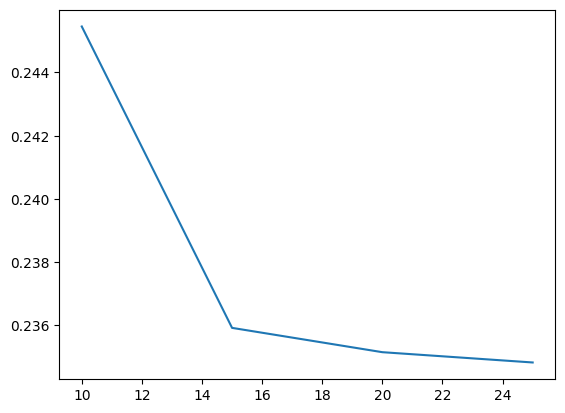

In [16]:
plt.plot(df_rmse.max_depth, df_rmse.rmse)

# Question 5

In [17]:
rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, max_depth=20, random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

rf.feature_importances_

array([0.01502087, 0.03030503, 0.10195626, 0.08627638, 0.3355917 ,
       0.29247297, 0.07380644, 0.02715851, 0.01589402, 0.02151783])

In [29]:
feats = {}
for feature, importance in zip(dv.feature_names_, rf.feature_importances_):
    feats[feature] = importance

print(feats)

df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False).head()

{'households': 0.015020868392390856, 'housing_median_age': 0.030305029123174957, 'latitude': 0.10195626000240125, 'longitude': 0.08627637578575545, 'median_income': 0.33559170042109715, 'ocean_proximity=<1H OCEAN': 0.29247296545343104, 'ocean_proximity=INLAND': 0.07380644294558006, 'population': 0.027158512272116596, 'total_bedrooms': 0.015894018592137876, 'total_rooms': 0.02151782701191468}


,feature,importance
4,median_income,0.335592
5,ocean_proximity=<1H OCEAN,0.292473
2,latitude,0.101956
3,longitude,0.086276
6,ocean_proximity=INLAND,0.073806


([0, 1, 2, 3],
 [Text(0, 0, 'total_rooms'),
  Text(1, 0, 'median_income'),
  Text(2, 0, 'total_bedrooms'),
  Text(3, 0, 'longitude')])

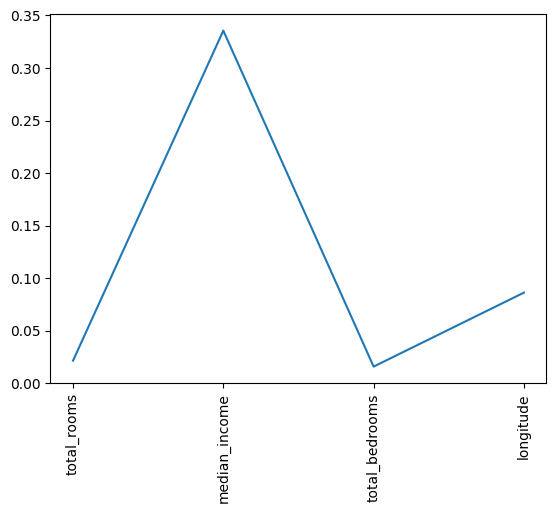

In [28]:
feat_subset = ['total_rooms', 'median_income', 'total_bedrooms', 'longitude']
feats_imp_subset = {k : feats[k] for k in feat_subset}
plt.plot(feats_imp_subset.keys(), feats_imp_subset.values())
plt.xticks(rotation='vertical')

# Question 6

In [20]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [33]:
features = dv.get_feature_names_out().tolist()
features = [f.replace('<', '') for f in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [34]:
%%capture output_03

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [35]:
scores['eta=0.3'] = parse_xgb_output(output_03)

In [36]:
%%capture output_01

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [37]:
scores['eta=0.1'] = parse_xgb_output(output_01)


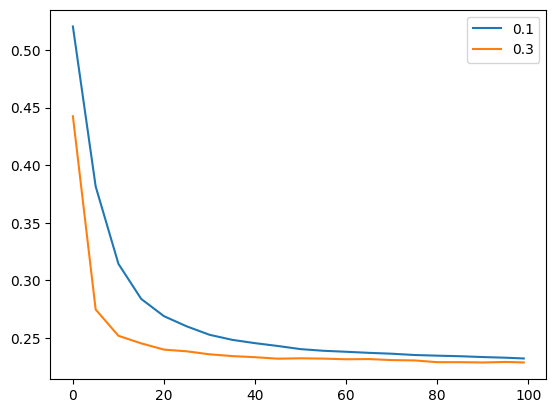

In [39]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_rmse,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_rmse,
        label='0.3')
plt.legend()
plt.show()